In [6]:
def create_bounding_box(center_x, center_y, buffer_meters):
    """
    Creates a bounding box around a center point with a specified buffer.

    Parameters:
        center_x (float): X coordinate of the center point.
        center_y (float): Y coordinate of the center point.
        buffer_meters (float): Buffer distance in meters.

    Returns:
        tuple: Bounding box as (min_x, min_y, max_x, max_y).
    """
    min_x = center_x - buffer_meters
    max_x = center_x + buffer_meters
    min_y = center_y - buffer_meters
    max_y = center_y + buffer_meters
    
    return min_x, min_y, max_x, max_y

# Example usage:
center_x = 4095913.19
center_y = 2287370.19
buffer_meters = 500  # Create a bounding box 1 km wide and tall (500m buffer on each side)

bounding_box = create_bounding_box(center_x, center_y, buffer_meters)
print("Bounding Box:", bounding_box)


from pyproj import Transformer

def translate_4326_to_3035(lon, lat):
    # Initialize the transformer for EPSG:4326 to EPSG:3035
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)

    return transformer.transform(lon, lat)

# Input coordinates in decimal degrees
longitude = 7.215861  # Longitude in EPSG:4326
latitude = 43.657722  # Latitude in EPSG:4326

translate_4326_to_3035(longitude, latitude)


Bounding Box: (4095413.19, 2286870.19, 4096413.19, 2287870.19)


(4095913.1894855704, 2287370.1853875336)

In [9]:
import requests
import rasterio
from rasterio.io import MemoryFile
import numpy as np

urls = {
    "airports": "https://noise.discomap.eea.europa.eu/arcgis/rest/services/noiseStoryMap/NoiseContours_air_lden/ImageServer/exportImage",
    "industry": "https://noise.discomap.eea.europa.eu/arcgis/rest/services/noiseStoryMap/NoiseContours_ind_lden/ImageServer/exportImage",
    "highways": "https://noise.discomap.eea.europa.eu/arcgis/rest/services/noiseStoryMap/NoiseContours_road_lden/ImageServer/exportImage",
    "railtracks": "https://noise.discomap.eea.europa.eu/arcgis/rest/services/noiseStoryMap/NoiseContours_rail_lden/ImageServer/exportImage"
}

pixel_to_noise = {
    1: 55,
    2: 60,
    3: 65,
    4: 70,
    5: 75,
    15: 0
}

def get_noise_values(url, lon, lat):

    x, y = translate_4326_to_3035(lon, lat)
    x_min, y_min, x_max, y_max = create_bounding_box(x, y, 500)

    params = {
        "bbox": f"{x_min},{y_min},{x_max},{y_max}",
        "bboxSR": "3035",
        "size": "800,600",       # Output resolution
        "format": "tiff",        # Request GeoTIFF
        "f": "image"             # Response type
    }

    # Fetch the GeoTIFF file
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # Use a memory file to avoid saving to disk
        with MemoryFile(response.content) as memfile:
            with memfile.open() as dataset:
                # Read the first band of data
                data = dataset.read(1)
                data = np.vectorize(pixel_to_noise.get)(data)
                return data
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

noise_layers = []


def combine_noise_levels(noise_layers):
    """
    Combine noise levels from multiple sources in Lden.
    
    Parameters:
        noise_layers (list of numpy arrays): Each array contains Lden values for a noise source.
    
    Returns:
        numpy array: Combined noise levels in Lden.
    """
    # Convert Lden to linear scale
    linear_sum = np.sum([10 ** (layer / 10) for layer in noise_layers if layer is not None], axis=0)
    
    # Convert back to Lden
    combined = 10 * np.log10(linear_sum)
    
    return combined

longitude = 7.215861  # Longitude in EPSG:4326
latitude = 43.657722  # Latitude in EPSG:4326

for t, url in urls.items():
    print(t)
    layer = get_noise_values(url, longitude, latitude)

    if layer is not None:
        noise_layers.append(layer)

if noise_layers:
    combined_noise = combine_noise_levels(noise_layers)

combined_noise


airports
industry
highways
railtracks


array([[75.04321401, 75.04321401, 75.04321401, ..., 75.04321401,
        75.04321401, 75.04321401],
       [75.04321401, 75.04321401, 75.04321401, ..., 75.04321401,
        75.04321401, 75.04321401],
       [75.04321401, 75.04321401, 75.04321401, ..., 75.04321401,
        75.04321401, 75.04321401],
       ...,
       [75.13520949, 75.13520949, 75.13520949, ..., 65.00000412,
        65.00000412, 65.00000412],
       [75.13520949, 75.13520949, 75.13520949, ..., 65.00000412,
        65.00000412, 65.00000412],
       [75.13520949, 75.13520949, 75.13520949, ..., 65.00000412,
        65.00000412, 65.00000412]])

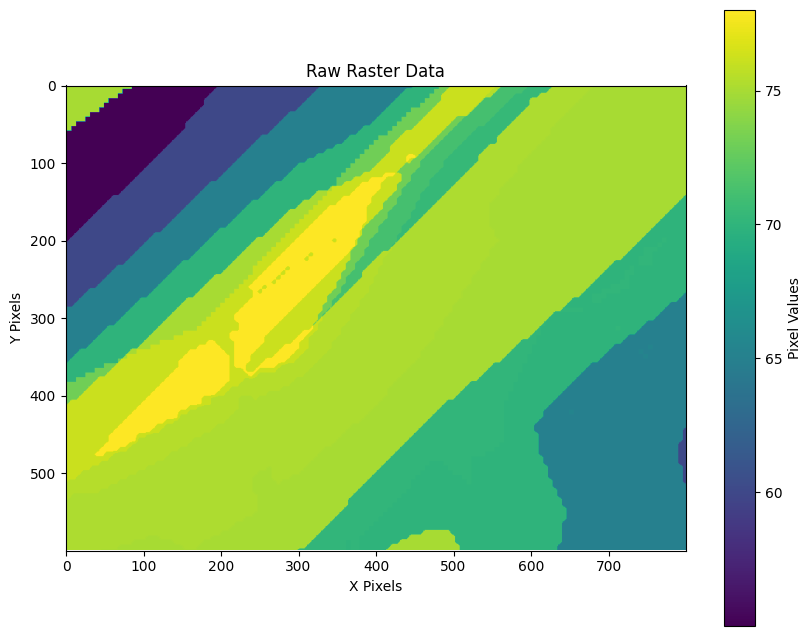

In [10]:
# Assuming 'data' is the raw pixel data read from the GeoTIFF
plot_raster(combined_noise, title="Raw Raster Data", colormap="viridis")

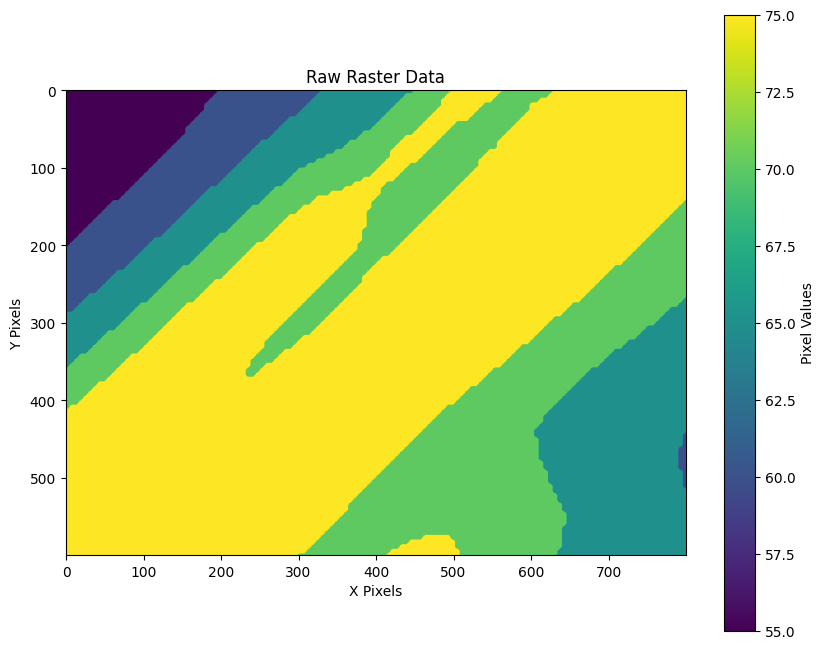

In [5]:
import matplotlib.pyplot as plt

def plot_raster(data, title="Raster Data", colormap="viridis"):
    """
    Plots the raster data using matplotlib.

    Parameters:
        data (numpy.ndarray): The 2D array of raster data.
        title (str): The title of the plot.
        colormap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap=colormap)
    plt.colorbar(label="Pixel Values")
    plt.title(title)
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")
    plt.grid(False)  # Disable grid for better visualization
    plt.show()

# Assuming 'data' is the raw pixel data read from the GeoTIFF
plot_raster(data, title="Raw Raster Data", colormap="viridis")


In [1]:
from windwhisper.ambient_noise import get_ambient_noise_levels

In [2]:
longitude = 7.215861  # Longitude in EPSG:4326
latitude = 43.657722  # Latitude in EPSG:4326
get_ambient_noise_levels(longitude, latitude)

<xarray.DataArray (y: 600, x: 800)> Size: 4MB
array([[75.04321401, 75.04321401, 75.04321401, ..., 75.04321401,
        75.04321401, 75.04321401],
       [75.04321401, 75.04321401, 75.04321401, ..., 75.04321401,
        75.04321401, 75.04321401],
       [75.04321401, 75.04321401, 75.04321401, ..., 75.04321401,
        75.04321401, 75.04321401],
       ...,
       [75.13520949, 75.13520949, 75.13520949, ..., 65.00000412,
        65.00000412, 65.00000412],
       [75.13520949, 75.13520949, 75.13520949, ..., 65.00000412,
        65.00000412, 65.00000412],
       [75.13520949, 75.13520949, 75.13520949, ..., 65.00000412,
        65.00000412, 65.00000412]])
Coordinates:
    lon      (y, x) float64 4MB 7.209 7.209 7.209 7.21 ... 7.222 7.222 7.222
    lat      (y, x) float64 4MB 43.66 43.66 43.66 43.66 ... 43.65 43.65 43.65
Dimensions without coordinates: y, x
Attributes:
    crs:        EPSG:4326
    long_name:  Combined Noise Levels
    units:      Lden (dB)